In [1]:
%load_ext autoreload
%autoreload 2

In [47]:
import pickle
import pkg_resources
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gymnasium as gym
import stable_baselines3 as sb3
import stable_baselines3.common.logger as logger
import stable_baselines3.common.callbacks as callbacks
import stable_baselines3.common.env_checker as env_checker
from dm_control import mjcf
from dm_control.rl.control import PhysicsError
import imageio
import scipy.spatial
import torch
import torch.nn as nn
import torch.optim as optim
import torch_geometric as pyg
import torch.nn.functional as F
import torch_geometric.nn as gnn
import torch_geometric.loader as pyg_loader
import pytorch_lightning as pl
import torchmetrics
from torch.utils.data import Dataset
from pathlib import Path
from typing import Tuple, Callable, Optional, List, Union
from tqdm import trange
from dm_control.rl.control import PhysicsError
from PIL import Image

from flygym.arena.mujoco_arena import FlatTerrain
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo, MuJoCoParameters
from flygym.state import stretched_pose
import flygym.util.vision as vision
import flygym.util.config as config
from flygym.arena import BaseArena
from flygym.arena.mujoco_arena import OdorArena, FlatTerrain, GappedTerrain, BlocksTerrain
from flygym.util.data import color_cycle_rgb

from rl_navigation import ObstacleOdorArena, NMFNavigation, VisualFeaturePreprocessor

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
with open("data/ommatidia_graph.pkl", "rb") as f:
    ommatidia_graph_nx = pickle.load(f)
ommatidia_graph_pg = pyg.utils.from_networkx(ommatidia_graph_nx)

In [5]:
vision_model = VisualFeaturePreprocessor.load_from_checkpoint(
    "data/models/visual_preprocessor.pt"
)

In [6]:
terrain_arena = FlatTerrain(ground_alpha=1)
arena = ObstacleOdorArena(
    terrain=terrain_arena,
    obstacle_positions=np.array([(7.5, 1.5), (12.5, -1.5)]),
    odor_source=np.array([[20, 0, 2]]),
    marker_size=0.5,
    obstacle_colors=(0.14, 0.14, 0.2, 1),
)
sim = NMFNavigation(
    arena=arena,
    vision_model=vision_model,
    ommatidia_graph=ommatidia_graph_pg,
    test_mode=True,
    debug_mode=True,
)
env_checker.check_env(sim)

/home/sibwang/anaconda3/envs/flygym/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


resetting environment
resetting environment
resetting environment
taking action [0.31390435 0.4606603 ]
fly_pos: [-0.18267354 -0.11831312], reward=-0.18302032323349948, state=seeking
updating last action to [0.31390435 0.4606603 ]
resetting environment
taking action [0.42125186 0.31983605]
fly_pos: [-0.21859903  0.03910285], reward=-0.21863683855389837, state=seeking
updating last action to [0.42125186 0.31983605]
taking action [0.6023438 0.7310121]
fly_pos: [0.09580008 0.47793376], reward=0.3086997409795167, state=seeking
updating last action to [0.6023438 0.7310121]
taking action [-0.6133555  -0.05146607]
fly_pos: [0.28780254 0.26238126], reward=0.1959934910888741, state=seeking
updating last action to [-0.6133555  -0.05146607]
taking action [0.44568965 0.9490428 ]
fly_pos: [0.57990474 0.15371101], reward=0.29324003687747435, state=seeking
updating last action to [0.44568965 0.9490428 ]
taking action [0.41285688 0.8805312 ]
fly_pos: [1.02838714 0.19474   ], reward=0.44809125303426, s

In [7]:
sim.reset()
for i in trange(10):
    obs, reward, terminated, truncated, info = sim.step(np.zeros((2,)))
    if terminated:
        break

resetting environment


  0%|          | 0/10 [00:00<?, ?it/s]

taking action [0. 0.]


 10%|█         | 1/10 [00:02<00:22,  2.45s/it]

fly_pos: [ 0.49038589 -0.08901445], reward=0.49018282496960097, state=seeking
updating last action to [0. 0.]
taking action [0. 0.]


 20%|██        | 2/10 [00:05<00:20,  2.53s/it]

fly_pos: [ 0.77903329 -0.0731803 ], reward=0.28871115792605906, state=seeking
updating last action to [0. 0.]
taking action [0. 0.]


 30%|███       | 3/10 [00:07<00:18,  2.71s/it]

fly_pos: [ 1.20574175 -0.00831978], reward=0.4268459261646882, state=seeking
updating last action to [0. 0.]
taking action [0. 0.]


 40%|████      | 4/10 [00:10<00:15,  2.56s/it]

fly_pos: [ 1.52044456 -0.00823603], reward=0.3147028188057668, state=seeking
updating last action to [0. 0.]
taking action [0. 0.]


 50%|█████     | 5/10 [00:12<00:12,  2.45s/it]

fly_pos: [2.01279001 0.09356006], reward=0.49210395694520415, state=seeking
updating last action to [0. 0.]
taking action [0. 0.]


 60%|██████    | 6/10 [00:14<00:09,  2.34s/it]

fly_pos: [2.46464241 0.04708433], reward=0.4520325148209423, state=seeking
updating last action to [0. 0.]
taking action [0. 0.]


 70%|███████   | 7/10 [00:16<00:06,  2.32s/it]

fly_pos: [3.00670646 0.11177925], reward=0.5417596332347436, state=seeking
updating last action to [0. 0.]
taking action [0. 0.]


 80%|████████  | 8/10 [00:19<00:04,  2.32s/it]

fly_pos: [3.43713473 0.14665812], reward=0.4301466050200453, state=seeking
updating last action to [0. 0.]
taking action [0. 0.]


 90%|█████████ | 9/10 [00:21<00:02,  2.21s/it]

fly_pos: [3.92759634 0.14514974], reward=0.49045549277629874, state=seeking
updating last action to [0. 0.]
taking action [0. 0.]


100%|██████████| 10/10 [00:23<00:00,  2.34s/it]

fly_pos: [4.53510985 0.21064745], reward=0.6067343681645561, state=seeking
updating last action to [0. 0.]


In [8]:
sim.save_video("test2.mp4", stabilization_time=0)

In [48]:
terrain_arena = FlatTerrain(ground_alpha=1)
arena = ObstacleOdorArena(
    terrain=terrain_arena,
    obstacle_positions=np.array([(7.5, 1.5), (12.5, -1.5)]),
    odor_source=np.array([[20, 0, 2]]),
    marker_size=0.5,
    obstacle_colors=(0.14, 0.14, 0.2, 1),
)
sim = NMFNavigation(
    spawn_pos=(0, -5, 0.2),
    arena=arena,
    vision_model=vision_model,
    ommatidia_graph=ommatidia_graph_pg,
    max_time=7,
    test_mode=True,
    debug_mode=True,
)
env_checker.check_env(sim)

resetting environment
resetting environment
resetting environment
fly_pos: [ 0.10991367 -4.80164253], reward=-0.9150747418322318, state=seeking
resetting environment
fly_pos: [ 0.1831123  -5.05838721], reward=-0.5193042526192961, state=seeking
fly_pos: [-0.09554352 -5.12409326], reward=-0.795825354069521, state=seeking
fly_pos: [ 0.06743664 -4.91153289], reward=-0.45890088851301414, state=seeking
fly_pos: [ 0.17336186 -4.99237878], reward=-0.36901334926390916, state=seeking
fly_pos: [ 0.35503405 -5.00444957], reward=0.10528268154376974, state=seeking
fly_pos: [ 0.91139214 -4.85547853], reward=0.3868167239317337, state=seeking
fly_pos: [ 1.37918845 -4.40962057], reward=0.14536671856603434, state=seeking
fly_pos: [ 1.73118614 -4.36022455], reward=0.06748342880307945, state=seeking
fly_pos: [ 2.2231544  -4.43313295], reward=0.32165827054309304, state=seeking
fly_pos: [ 2.8241778  -4.38699273], reward=0.4945303071520186, state=seeking


resetting environment


  0%|          | 0/30 [00:00<?, ?it/s]

fly_pos: [-0.08020011 -4.7809033 ], reward=-0.641498806354118, state=seeking
(721, 2) 255.00000000000102
(721, 2) 255.00000000000102


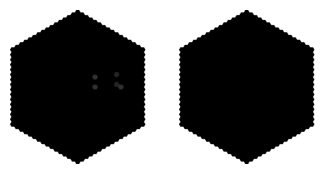

  3%|▎         | 1/30 [00:02<01:04,  2.23s/it]

fly_pos: [ 0.07949384 -4.75947135], reward=0.16030906311354443, state=seeking
(721, 2) 255.00000000000102
(721, 2) 255.00000000000102


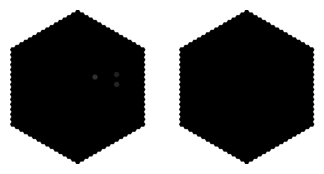

  7%|▋         | 2/30 [00:05<01:16,  2.74s/it]

fly_pos: [ 0.25973074 -4.74871272], reward=0.1777786288764176, state=seeking
(721, 2) 255.00000000000102
(721, 2) 255.00000000000102


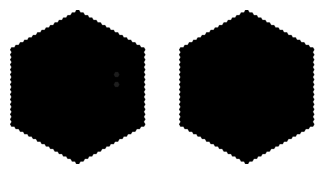

 10%|█         | 3/30 [00:08<01:21,  3.02s/it]

fly_pos: [ 0.43144295 -4.67486935], reward=0.18419571317881278, state=seeking
(721, 2) 255.00000000000102
(721, 2) 255.00000000000102


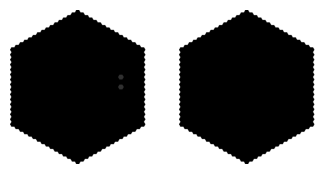

 13%|█▎        | 4/30 [00:11<01:14,  2.85s/it]

fly_pos: [ 0.82238532 -4.43809248], reward=0.43476545587618176, state=seeking
(721, 2) 255.00000000000102
(721, 2) 255.00000000000102


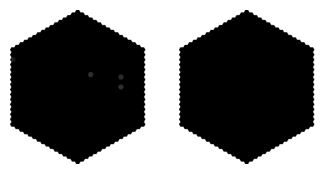

 17%|█▋        | 5/30 [00:14<01:11,  2.86s/it]

fly_pos: [ 1.25642362 -4.45349192], reward=0.41906009752135276, state=seeking
(721, 2) 255.00000000000102
(721, 2) 255.00000000000102


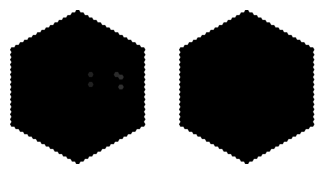

 20%|██        | 6/30 [00:16<01:04,  2.67s/it]

fly_pos: [ 1.78764498 -4.37786961], reward=0.53424953040631, state=seeking
(721, 2) 255.00000000000102
(721, 2) 255.00000000000102


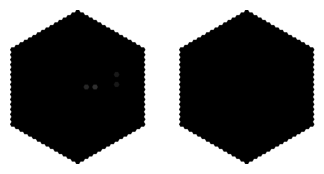

 23%|██▎       | 7/30 [00:18<00:59,  2.58s/it]

fly_pos: [ 2.21429879 -4.34159915], reward=0.42320076878282364, state=seeking
(721, 2) 255.00000000000102
(721, 2) 255.00000000000102


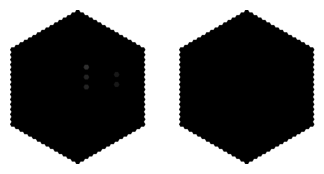

 27%|██▋       | 8/30 [00:21<00:55,  2.53s/it]

fly_pos: [ 2.69097103 -4.27221635], reward=0.47947027797296826, state=seeking
(721, 2) 255.00000000000102
(721, 2) 255.00000000000102


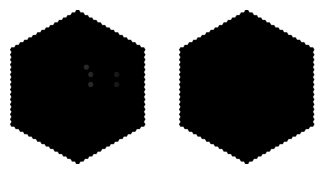

 30%|███       | 9/30 [00:23<00:50,  2.39s/it]

fly_pos: [ 3.19791744 -4.17723289], reward=0.5149123631829085, state=seeking
(721, 2) 255.00000000000102
(721, 2) 255.00000000000102


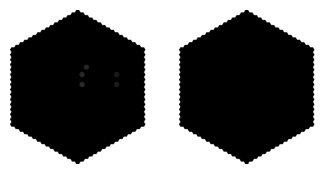

 33%|███▎      | 10/30 [00:25<00:47,  2.38s/it]

fly_pos: [ 3.77856788 -4.17333077], reward=0.5638837856833554, state=seeking
(721, 2) 255.00000000000102
(721, 2) 255.00000000000102


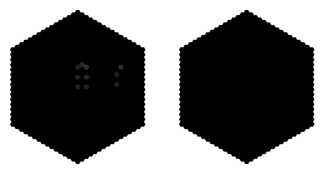

 37%|███▋      | 11/30 [00:27<00:44,  2.34s/it]

fly_pos: [ 4.32712587 -4.01689303], reward=0.5702289698144511, state=seeking
(721, 2) 255.00000000000102
(721, 2) 255.00000000000102


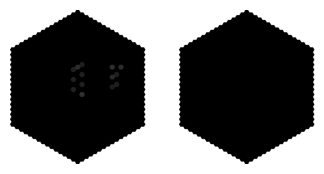

 40%|████      | 12/30 [00:30<00:41,  2.33s/it]

fly_pos: [ 4.80434519 -3.9770925 ], reward=0.4719558112986384, state=seeking
(721, 2) 255.00000000000102
(721, 2) 255.00000000000102


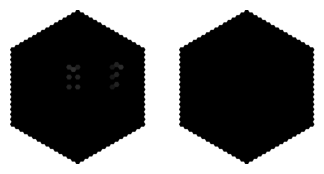

 43%|████▎     | 13/30 [00:32<00:40,  2.37s/it]

fly_pos: [ 5.23758229 -3.95741156], reward=0.423834230078306, state=seeking
(721, 2) 255.00000000000102
(721, 2) 255.00000000000057


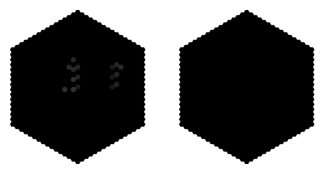

 47%|████▋     | 14/30 [00:34<00:37,  2.33s/it]

fly_pos: [ 5.76261248 -3.89145277], reward=0.5240264704784181, state=seeking
(721, 2) 255.00000000000102
(721, 2) 255.00000000000102


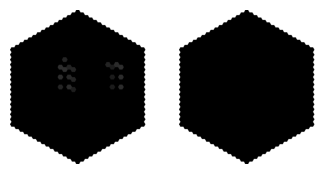

 50%|█████     | 15/30 [00:37<00:34,  2.32s/it]

fly_pos: [ 6.24762388 -3.97292742], reward=0.4448799539539916, state=seeking
(721, 2) 255.00000000000102
(721, 2) 255.00000000000102


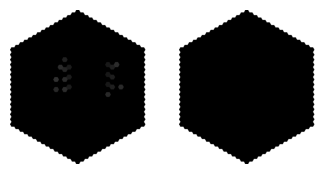

 53%|█████▎    | 16/30 [00:39<00:31,  2.27s/it]

fly_pos: [ 6.81113733 -3.83631056], reward=0.5792689067422803, state=seeking
(721, 2) 255.00000000000102
(721, 2) 255.00000000000102


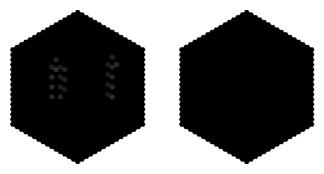

 57%|█████▋    | 17/30 [00:41<00:29,  2.25s/it]

fly_pos: [ 7.2896308  -3.81648492], reward=0.4644938007293362, state=seeking
(721, 2) 255.00000000000102
(721, 2) 255.00000000000102


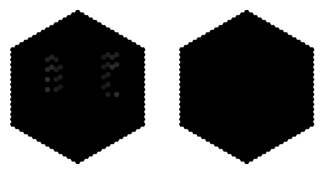

 60%|██████    | 18/30 [00:43<00:27,  2.28s/it]

fly_pos: [ 7.71108806 -3.82587917], reward=0.4002931560121308, state=seeking
(721, 2) 255.00000000000102
(721, 2) 255.00000000000057


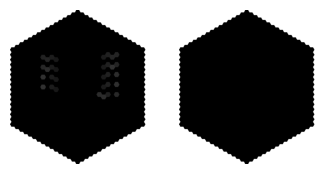

 63%|██████▎   | 19/30 [00:46<00:24,  2.26s/it]

fly_pos: [ 8.18593682 -3.75525161], reward=0.47415990989975576, state=seeking
(721, 2) 255.00000000000102
(721, 2) 255.00000000000102


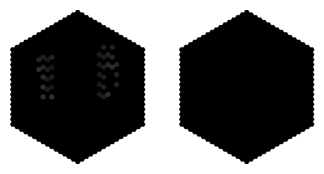

 67%|██████▋   | 20/30 [00:48<00:22,  2.28s/it]

fly_pos: [ 8.69946569 -3.78210604], reward=0.4798880171458535, state=seeking
(721, 2) 255.00000000000102
(721, 2) 255.00000000000102


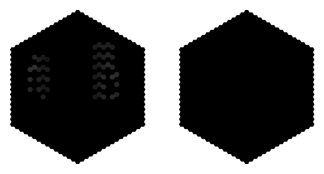

 70%|███████   | 21/30 [00:50<00:20,  2.28s/it]

fly_pos: [ 9.25441162 -3.72953413], reward=0.5422386589069745, state=seeking
(721, 2) 255.00000000000102
(721, 2) 255.00000000000102


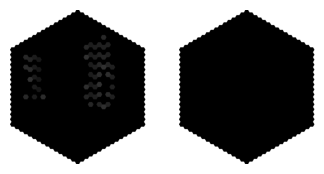

 73%|███████▎  | 22/30 [00:53<00:18,  2.27s/it]

fly_pos: [ 9.70990877 -3.72166166], reward=0.4319766615683438, state=seeking
(721, 2) 255.00000000000102
(721, 2) 255.00000000000102


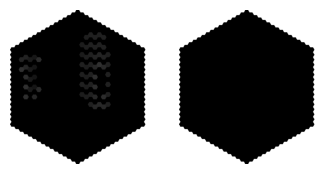

 77%|███████▋  | 23/30 [00:55<00:15,  2.28s/it]

fly_pos: [10.20122985 -3.71076361], reward=0.4645631875735621, state=seeking
(721, 2) 255.00000000000057
(721, 2) 255.00000000000057


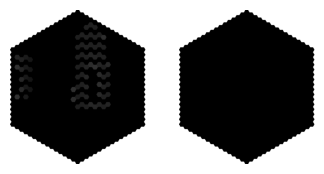

 80%|████████  | 24/30 [00:57<00:13,  2.30s/it]

fly_pos: [10.72464294 -3.68256313], reward=0.4982100929523856, state=seeking
(721, 2) 255.00000000000102
(721, 2) 255.00000000000102


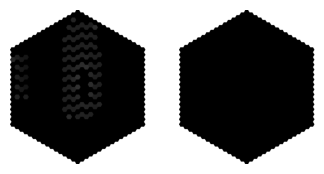

 83%|████████▎ | 25/30 [01:00<00:11,  2.32s/it]

fly_pos: [11.27322824 -3.76908478], reward=-10.0, state=collision
terminated
(721, 2) 255.00000000000102
(721, 2) 255.00000000000102


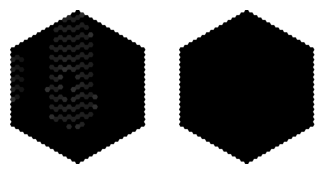

 83%|████████▎ | 25/30 [01:02<00:12,  2.49s/it]

terminated


In [59]:
from flygym.util.vision import hex_pxls_to_human_readable

obs_hist = []
reward_hist = []
action_hist = []
obs, info = sim.reset()
for i in trange(30):
    action = np.array([0, 0])
    action_hist.append(action)
    obs, reward, terminated, truncated, info = sim.step(action)
    fig, axs = plt.subplots(1, 2, figsize=(4, 2))
    for i in range(2):
        visual_inputs = sim.curr_visual_input[i, :, :]
        print(visual_inputs.shape, visual_inputs.max())
        visual_inputs[:, 1] = 0
        visual_inputs[:, 0][visual_inputs[:, 0] > 50] = 0
        img = hex_pxls_to_human_readable(visual_inputs)
        axs[i].imshow(img, cmap="gray", vmin=0, vmax=255)
        axs[i].axis("off")
    plt.show()
    
    obs_hist.append(obs)
    reward_hist.append(reward)
    if terminated:
        print("terminated")
        break

obs_hist = np.array(obs_hist)
reward_hist = np.array(reward_hist)
action_hist = np.array(action_hist)

sim.save_video("test2.mp4")

In [32]:
np.random.seed(0)
sb3.common.utils.set_random_seed(0, using_cuda=True)

start_from = "logs/trial_7/trial_7_18000_steps.zip"
train = False

log_dir = "logs/trial_6"
checkpoint_callback = callbacks.CheckpointCallback(
    save_freq=1000,
    save_path=log_dir,
    name_prefix="trial_6",
    save_replay_buffer=True,
    save_vecnormalize=True,
)
my_logger = logger.configure(log_dir, ["tensorboard", "stdout", "csv"])
model = sb3.SAC(
    "MlpPolicy",
    env=sim,
    policy_kwargs={"net_arch": [16, 16]},
    verbose=2,
    learning_rate=0.01,
)
if start_from is not None:
    model = sb3.SAC.load(start_from)
model.set_logger(my_logger)

if train:
    model.learn(total_timesteps=50_000, progress_bar=True, callback=checkpoint_callback)
    model.save("models/trial_6")


obs_hist = []
reward_hist = []
action_hist = []
obs, info = sim.reset()
for i in trange(70):
    action, _states = model.predict(obs, deterministic=True)
    action_hist.append(action)
    obs, reward, terminated, truncated, info = sim.step(action)
    obs_hist.append(obs)
    reward_hist.append(reward)
    if terminated:
        print("terminated")
        break

obs_hist = np.array(obs_hist)
reward_hist = np.array(reward_hist)
action_hist = np.array(action_hist)

sim.save_video(Path(start_from).stem + ".mp4")

Logging to logs/trial_6


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
resetting environment


  1%|▏         | 1/70 [00:02<02:24,  2.10s/it]

fly_pos: [ 0.20672667 -0.05264531], reward=0.08192851902722253, state=seeking


  3%|▎         | 2/70 [00:04<02:38,  2.32s/it]

fly_pos: [0.20640416 0.03189156], reward=-0.5612023037736797, state=seeking


  4%|▍         | 3/70 [00:07<02:51,  2.56s/it]

fly_pos: [ 0.41741882 -0.00652955], reward=0.1886276731709735, state=seeking


  6%|▌         | 4/70 [00:09<02:38,  2.40s/it]

fly_pos: [ 0.09049726 -0.50094989], reward=-0.3556333469001203, state=seeking


  7%|▋         | 5/70 [00:12<02:44,  2.53s/it]

fly_pos: [-0.00562133 -1.08178469], reward=-0.11904417956749924, state=seeking


  9%|▊         | 6/70 [00:14<02:33,  2.40s/it]

fly_pos: [-0.25040106 -0.89561021], reward=-0.23534815751118998, state=seeking


 10%|█         | 7/70 [00:16<02:28,  2.36s/it]

fly_pos: [-0.33565895 -1.0289167 ], reward=-0.09147582287712908, state=seeking


 11%|█▏        | 8/70 [00:18<02:15,  2.18s/it]

fly_pos: [-0.27728524 -1.063163  ], reward=0.05653460887932127, state=seeking


 13%|█▎        | 9/70 [00:20<02:10,  2.14s/it]

fly_pos: [-0.38665401 -1.21921084], reward=-0.11794094763001084, state=seeking


 14%|█▍        | 10/70 [00:22<02:10,  2.17s/it]

fly_pos: [-0.02255347 -1.59814244], reward=0.33684675801245234, state=seeking


 16%|█▌        | 11/70 [00:24<02:06,  2.14s/it]

fly_pos: [ 0.08456793 -1.47121403], reward=0.11653209911809626, state=seeking


 17%|█▋        | 12/70 [00:27<02:07,  2.20s/it]

fly_pos: [ 0.34994162 -1.98380367], reward=0.21975609315117595, state=seeking


 19%|█▊        | 13/70 [00:29<02:02,  2.15s/it]

fly_pos: [ 0.34340643 -1.75437982], reward=0.015214821690797464, state=seeking


 20%|██        | 14/70 [00:31<01:59,  2.13s/it]

fly_pos: [ 0.23212863 -1.95847847], reward=-0.12992266870102753, state=seeking


 21%|██▏       | 15/70 [00:33<02:00,  2.19s/it]

fly_pos: [ 0.67689469 -2.31809686], reward=0.02488856343904544, state=seeking


 23%|██▎       | 16/70 [00:36<02:01,  2.24s/it]

fly_pos: [ 0.39601032 -1.89067831], reward=-0.6114056042515159, state=seeking


 24%|██▍       | 17/70 [00:38<01:57,  2.21s/it]

fly_pos: [ 0.88893485 -2.34068798], reward=0.4410773571925226, state=seeking


 26%|██▌       | 18/70 [00:40<01:50,  2.13s/it]

fly_pos: [ 0.72192171 -2.25781071], reward=-0.15597001590665016, state=seeking


 27%|██▋       | 19/70 [00:42<01:49,  2.14s/it]

fly_pos: [ 0.71801357 -2.19778496], reward=0.0030077887501498424, state=seeking


 29%|██▊       | 20/70 [00:44<01:45,  2.12s/it]

fly_pos: [ 1.00749595 -2.5387598 ], reward=0.24540246158771595, state=seeking


 30%|███       | 21/70 [00:46<01:42,  2.09s/it]

fly_pos: [ 0.75779026 -2.38123114], reward=-0.2275561528909371, state=seeking


 31%|███▏      | 22/70 [00:48<01:43,  2.15s/it]

fly_pos: [ 1.16375353 -2.81360949], reward=0.3437644855723967, state=seeking


 33%|███▎      | 23/70 [00:50<01:36,  2.05s/it]

fly_pos: [ 0.8880027  -2.79499344], reward=-0.2700654507375688, state=seeking


 34%|███▍      | 24/70 [00:52<01:36,  2.11s/it]

fly_pos: [ 1.14773664 -2.8525425 ], reward=0.2484383751136221, state=seeking


 36%|███▌      | 25/70 [00:55<01:36,  2.16s/it]

fly_pos: [ 1.36301038 -3.21630737], reward=-0.12504830502978947, state=seeking


 37%|███▋      | 26/70 [00:57<01:37,  2.21s/it]

fly_pos: [ 1.43609339 -3.0095275 ], reward=-0.17320634062759055, state=seeking


 39%|███▊      | 27/70 [00:59<01:37,  2.26s/it]

fly_pos: [ 1.5899006  -3.90452242], reward=-0.01331985447108508, state=seeking


 40%|████      | 28/70 [01:01<01:34,  2.25s/it]

fly_pos: [ 1.53513085 -3.40441367], reward=0.043505804234566625, state=seeking


 41%|████▏     | 29/70 [01:04<01:32,  2.25s/it]

fly_pos: [ 1.7515691  -4.26509711], reward=0.03585483521104749, state=seeking


 43%|████▎     | 30/70 [01:06<01:28,  2.22s/it]

fly_pos: [ 1.4381831  -4.13999035], reward=-0.27766953515698845, state=seeking


 44%|████▍     | 31/70 [01:08<01:28,  2.26s/it]

fly_pos: [ 1.69875457 -4.10765917], reward=0.2613437499560831, state=seeking


 46%|████▌     | 32/70 [01:10<01:23,  2.20s/it]

fly_pos: [ 1.47053391 -4.87376895], reward=-0.40315905426468746, state=seeking


 47%|████▋     | 33/70 [01:12<01:20,  2.18s/it]

fly_pos: [ 1.68494205 -4.57015812], reward=0.2830724153476467, state=seeking


 49%|████▊     | 34/70 [01:15<01:18,  2.17s/it]

fly_pos: [ 1.530739   -5.57949893], reward=-0.4169924122462234, state=seeking


 50%|█████     | 35/70 [01:17<01:14,  2.13s/it]

fly_pos: [ 1.32533009 -5.38072594], reward=-0.5189719555589356, state=seeking


 51%|█████▏    | 36/70 [01:19<01:11,  2.11s/it]

fly_pos: [ 1.19100486 -5.83537954], reward=-0.6372275326984429, state=seeking


 53%|█████▎    | 37/70 [01:21<01:08,  2.08s/it]

fly_pos: [ 0.48236092 -5.38760993], reward=-0.7374175388275681, state=seeking


 54%|█████▍    | 38/70 [01:22<01:03,  1.99s/it]

fly_pos: [ 0.5221417  -5.99638234], reward=-0.3156318156851299, state=seeking


 56%|█████▌    | 39/70 [01:24<01:00,  1.94s/it]

fly_pos: [-0.16648466 -6.02272229], reward=-0.8947276379258398, state=seeking


 57%|█████▋    | 40/70 [01:26<00:58,  1.94s/it]

fly_pos: [-0.13528494 -6.39270219], reward=-0.17792598026666084, state=seeking


 59%|█████▊    | 41/70 [01:28<00:58,  2.03s/it]

fly_pos: [-0.28096331 -6.47805268], reward=-0.30547293586526436, state=seeking


 60%|██████    | 42/70 [01:31<00:57,  2.06s/it]

fly_pos: [-0.50073612 -6.92209808], reward=-0.5477249411032084, state=seeking


 61%|██████▏   | 43/70 [01:33<00:56,  2.11s/it]

fly_pos: [-0.70794765 -7.13752274], reward=-0.28677196649646675, state=seeking


 63%|██████▎   | 44/70 [01:35<00:54,  2.08s/it]

fly_pos: [-1.09671138 -7.48808499], reward=-0.5155823797957879, state=seeking


 64%|██████▍   | 45/70 [01:37<00:53,  2.12s/it]

fly_pos: [-1.15048756 -7.81470407], reward=-0.45699580501096904, state=seeking


 66%|██████▌   | 46/70 [01:39<00:50,  2.08s/it]

fly_pos: [-2.08529823 -8.14453593], reward=-1.094227449661286, state=seeking


 67%|██████▋   | 47/70 [01:41<00:47,  2.07s/it]

fly_pos: [-2.18108678 -8.59142983], reward=-0.6082721738112653, state=seeking


 69%|██████▊   | 48/70 [01:44<00:48,  2.19s/it]

fly_pos: [-2.49594371 -8.3914454 ], reward=-0.43605149770895935, state=seeking


 70%|███████   | 49/70 [01:46<00:46,  2.21s/it]

fly_pos: [-2.1110158  -8.13046898], reward=0.37162367457382217, state=seeking


 71%|███████▏  | 50/70 [01:48<00:43,  2.17s/it]

fly_pos: [-2.25312116 -7.70182842], reward=-0.2175888487283011, state=seeking


 73%|███████▎  | 51/70 [01:50<00:40,  2.12s/it]

fly_pos: [-2.56822832 -7.56641553], reward=-0.6153838909377285, state=seeking


 74%|███████▍  | 52/70 [01:52<00:38,  2.13s/it]

fly_pos: [-2.33937562 -7.67590486], reward=-0.17925665921435652, state=seeking


 76%|███████▌  | 53/70 [01:54<00:36,  2.15s/it]

fly_pos: [-2.77914382 -7.42163096], reward=-0.33634126342714765, state=seeking


 77%|███████▋  | 54/70 [01:56<00:34,  2.17s/it]

fly_pos: [-2.56175982 -7.54969324], reward=0.16626763109167086, state=seeking


 79%|███████▊  | 55/70 [01:59<00:32,  2.15s/it]

fly_pos: [-2.50853993 -7.27076207], reward=0.1376858764535065, state=seeking


 80%|████████  | 56/70 [02:01<00:30,  2.18s/it]

fly_pos: [-2.6850064  -7.10888828], reward=-0.27369870578194266, state=seeking


 81%|████████▏ | 57/70 [02:03<00:27,  2.12s/it]

fly_pos: [-2.81853477 -6.99038077], reward=-0.24709174849326487, state=seeking


 83%|████████▎ | 58/70 [02:05<00:24,  2.08s/it]

fly_pos: [-3.29070384 -6.80421762], reward=-0.3989923080283866, state=seeking


 84%|████████▍ | 59/70 [02:07<00:22,  2.06s/it]

fly_pos: [-3.22977423 -6.9314021 ], reward=0.02242021300261854, state=seeking


 86%|████████▌ | 60/70 [02:09<00:21,  2.10s/it]

fly_pos: [-3.27568452 -6.7929527 ], reward=-0.0048454883224025025, state=seeking


 87%|████████▋ | 61/70 [02:11<00:19,  2.13s/it]

fly_pos: [-3.59439141 -6.76018829], reward=-0.29810440701432483, state=seeking


 89%|████████▊ | 62/70 [02:13<00:17,  2.14s/it]

fly_pos: [-3.49783381 -6.62413839], reward=0.1290302513108088, state=seeking


 90%|█████████ | 63/70 [02:16<00:15,  2.19s/it]

fly_pos: [-4.03221237 -6.40131122], reward=-0.45647061831763835, state=seeking


 91%|█████████▏| 64/70 [02:18<00:12,  2.14s/it]

fly_pos: [-4.04395843 -6.54585512], reward=-0.04892906217377302, state=seeking


 93%|█████████▎| 65/70 [02:20<00:10,  2.15s/it]

fly_pos: [-4.20655397 -6.39637096], reward=-0.11831623136936642, state=seeking


 94%|█████████▍| 66/70 [02:22<00:08,  2.15s/it]

fly_pos: [-4.44264163 -6.38587265], reward=-0.22592007842779438, state=seeking


 96%|█████████▌| 67/70 [02:24<00:06,  2.16s/it]

fly_pos: [-4.36113738 -6.27520832], reward=0.10643152745308271, state=seeking


 97%|█████████▋| 68/70 [02:26<00:04,  2.20s/it]

fly_pos: [-4.85351953 -5.95194254], reward=-0.3998962770276826, state=seeking


 99%|█████████▊| 69/70 [02:29<00:02,  2.16s/it]

fly_pos: [-4.77821495 -6.13059301], reward=0.03091025099039868, state=seeking


100%|██████████| 70/70 [02:31<00:00,  2.16s/it]

fly_pos: [-5.17345575 -5.8366281 ], reward=-0.31586669225010766, state=seeking


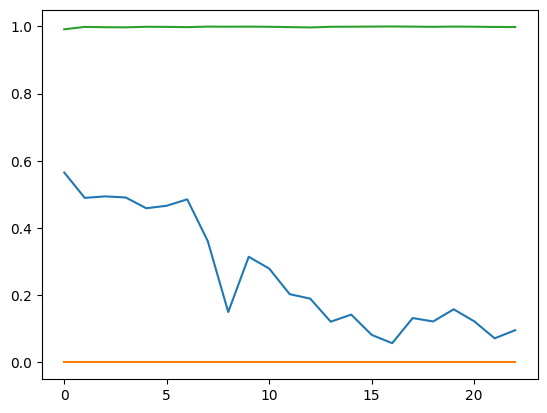

In [51]:
plt.plot(obs_hist[:, 0])
plt.plot(obs_hist[:, 1])
plt.plot(obs_hist[:, 2])

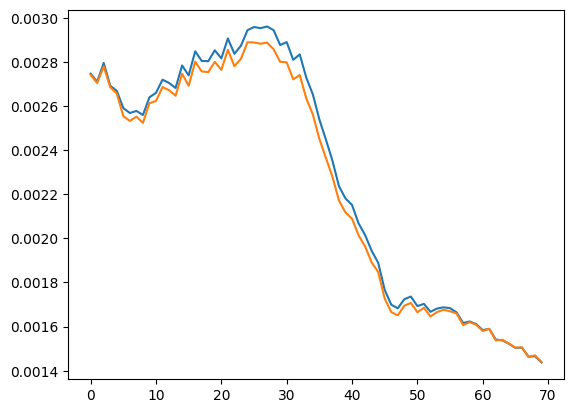

In [35]:
plt.plot(obs_hist[:, 3])
plt.plot(obs_hist[:, 4])

IndexError: index 1 is out of bounds for axis 1 with size 1

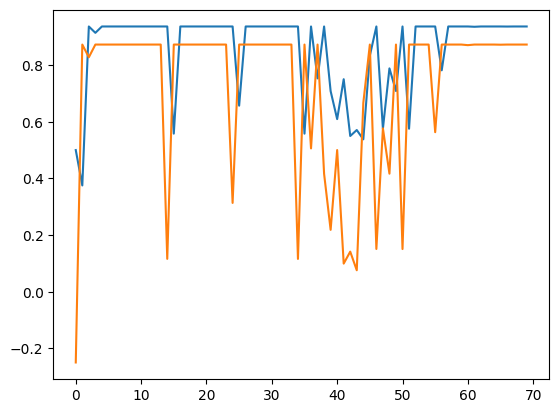

In [36]:
plt.plot(obs_hist[:, 5])
plt.plot(action_hist[:, 0])
plt.plot(action_hist[:, 1])